In [58]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

import torch
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler


In [59]:
class Inventory():
    def __init__(self, starting_cash):
        self.profit = 0
        self.total_reward = 0
        self.shares_owned = 0
        self.buy_transactions = {}
        self.last_sell_price = None
        self.cash = starting_cash
        self.strategy_vol = 0
        self.last_obs_vol = 0

        self.sharpe_ratio = 0 # !!! Implement method

    def reset(self, starting_cash):
        self.profit = 0
        self.total_reward = 0
        self.shares_owned = 0
        self.buy_transactions = {}
        self.last_sell_price = None
        self.cash = starting_cash
        self.strategy_vol = 0
        self.last_obs_vol = 0

# Trade Env

In [60]:
class TradeEnv(gym.Env):
    def __init__(self, input_dim=15, window_size=5, day_length=1440, df_list: list=None, inventory=Inventory(1000)):
        super(TradeEnv, self).__init__()
        self.window_size=window_size
        self.action_space = spaces.Discrete(3) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, input_dim), dtype=np.float64)
        self.max_steps = day_length  # episode terminates when day ends

        self.dataframes = [self.reformat_time_feature(self.calculate_macd(self.calculate_rsi(df))).to_numpy() for df in df_list]
        self.inventory = inventory

        self.currency_df = None
        self.position = 0

        self.initial_cash = self.inventory.cash
        self.state = None
        self.current_price = 0

        self.profit_per_episode = []
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        

    def step(self, action):
        self.position += 1

        terminated = self.position == self.max_steps    # day ends
        truncated = self.position == self.currency_df.shape[0] - 1  # end of dataframe is reached

        reward = self.calculate_pnl(action)
        self.state = self.update_state()
        
        info = {"Profit": self.inventory.profit,
                "Cash": self.inventory.cash,
                "Shares Owned": self.inventory.shares_owned}

        if terminated or truncated:
            self.profit_per_episode.append(self.inventory.profit)

        print(info)

        return self.state, reward, terminated, truncated, info
    
    def update_state(self):
        inventory_state = np.concatenate((self.state[1:, -3:], np.array([[self.inventory.cash, self.inventory.profit, self.inventory.shares_owned]])))
        self.state = np.concatenate((self.currency_df[self.position-self.window_size+1:self.position+1], inventory_state), axis=1)
        return self.state
    

    def reset(self, seed: Optional[int] = None):
        super().reset(seed=seed)
        self.inventory.reset(self.initial_cash)
        self.current_price = 0

        self.currency_df = np.random.choice(self.dataframes)
        self.position = np.random.randint(self.currency_df.shape[0])

        inventory_state = np.ones(shape=(5, 3)) * np.array([self.inventory.cash, self.inventory.profit, self.inventory.shares_owned])

        if self.position < self.window_size - 1:
            self.position = self.window_size - 1

        self.state = np.concatenate((self.currency_df[self.position-self.window_size+1:self.position+1], inventory_state), axis=1)

        info = {'Profit': self.inventory.profit,
                'Cash': self.inventory.cash}

        return self.state, info
    
    # def render(self, mode='human', close=False):
    #     if close:
    #         plt.close(self.fig)
    #         return
        
    #     # Update the plot with the latest profit data
    #     self.ax.clear()
    #     self.ax.plot(self.profit_per_episode, label='Profit per Episode')
    #     self.ax.set_xlabel('Episode')
    #     self.ax.set_ylabel('Profit')
    #     self.ax.set_title('Profit Per Episode')
    #     self.ax.legend()
    #     self.ax.grid(True)

    #     # Redraw the plot
    #     plt.pause(0.001)
    #     clear_output(wait=True)
    #     plt.show()
    
    def calculate_pnl(self, action):
        self.current_price = self.state[-1, 3]

        if action == 0:  # Buy
            if self.inventory.cash:
                position_size = self.calculate_position_size()
                self.inventory.cash -= self.current_price * position_size
                self.inventory.shares_owned += position_size
                self.inventory.buy_transactions[self.current_price] = position_size
            if self.state[-1, 6] < 50 and self.state[-1, 7] > 0: 
                reward = 1
            else:
                reward = -1

        elif action == 1:  # Sell
            if self.inventory.shares_owned > 0:
                self.inventory.cash += self.inventory.shares_owned * self.current_price
                reward = self.inventory.shares_owned * self.current_price - sum([key * val for key, val in self.inventory.buy_transactions.items()])
                self.inventory.buy_transactions = {}

                self.inventory.shares_owned = 0
                self.inventory.last_sell_price = self.current_price
                self.inventory.profit += reward
            else:
                reward = -1

        elif action == 2:  # Hold
            reward = -0.01

        return reward
    
    def calculate_position_size(self):
        self.inventory.last_obs_vol = np.std(self.state[:, 3])
        position_size =  min(self.inventory.cash / self.inventory.last_obs_vol, self.inventory.cash * 0.3) / self.state[-1, 3]
        return position_size
    
    def calculate_rsi(self, df):
        period = self.window_size
        df['delta'] = df['Close'].diff(1)
        df['gain'] = df['delta'].clip(lower=0)
        df['loss'] = df['delta'].clip(upper=0)
        avg_gain = df['gain'].ewm(com=period-1, adjust=False, min_periods = period).mean()
        avg_loss = abs(df['loss'].ewm(com=period-1, adjust=False, min_periods = period).mean())
        rs = avg_gain / avg_loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df.drop(columns=['delta', 'gain', 'loss'], inplace=True)
        return df

    def calculate_macd(self, df, fast=3, slow=5, signal=2):
        fast_ema = df['Close'].ewm(span=fast, min_periods=fast, adjust=False).mean()
        slow_ema = df['Close'].ewm(span=slow, min_periods=slow, adjust=False).mean()
        df['macd'] = fast_ema - slow_ema
        df['signal_line'] = df['macd'].ewm(span=signal, min_periods=fast, adjust=False).mean()
        df['macd_h'] = df['macd'] - df['signal_line']
        df.dropna(inplace=True)
        return df
    
    def reformat_time_feature(self, df):
        df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x))
        df['Time'] = df['Time'].dt.hour * 60 + df['Time'].dt.minute
        df['cos_time'] = np.cos(2 * np.pi * df['Time'] / 1440)
        df['sin_time'] = np.sin(2 * np.pi * df['Time'] / 1440)
        df.drop(columns='Time', inplace=True)
        return df

# Tests

In [64]:
currencies = ['AVAX', 'DOT', 'ETH', 'SOL', 'XBT']
df_list = []
for currency in currencies:
    df = pd.read_csv(f'trading_train_data/{currency}_train.csv')
    df_list.append(df)

Using cpu device
{'Profit': 0, 'Cash': 957.4936570490432, 'Shares Owned': 0.0015433113048277291}
{'Profit': 0.04707099479724519, 'Cash': 1000.0470709947972, 'Shares Owned': 0}
{'Profit': 0.04707099479724519, 'Cash': 954.4962507052657, 'Shares Owned': 0.0016512655350124172}
{'Profit': 0.04707099479724519, 'Cash': 954.4962507052657, 'Shares Owned': 0.0016512655350124172}
{'Profit': 0.04707099479724519, 'Cash': 915.5777740001, 'Shares Owned': 0.00306476097530027}
{'Profit': -0.25193705035078295, 'Cash': 999.7480629496491, 'Shares Owned': 0}
{'Profit': -0.25193705035078295, 'Cash': 980.2506832765339, 'Shares Owned': 0.0007105070667826203}
{'Profit': -0.25193705035078295, 'Cash': 980.2506832765339, 'Shares Owned': 0.0007105070667826203}
{'Profit': -0.25193705035078295, 'Cash': 962.3333102804385, 'Shares Owned': 0.0013653291569689129}
{'Profit': -0.25193705035078295, 'Cash': 962.3333102804385, 'Shares Owned': 0.0013653291569689129}
{'Profit': -0.1813046491485366, 'Cash': 999.8186953508514, '

/var/folders/k4/9m82lrns3_b1px7jygrrtg300000gn/T/ipykernel_50946/479124300.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.currency_df = np.random.choice(self.dataframes)


{'Profit': 0.5407285700031874, 'Cash': 931.568683723539, 'Shares Owned': 0.002480223700643842}
{'Profit': 0.8071045954523495, 'Cash': 1000.8071045954526, 'Shares Owned': 0}
{'Profit': 0.8071045954523495, 'Cash': 1000.8071045954526, 'Shares Owned': 0}
{'Profit': 0.8071045954523495, 'Cash': 1000.8071045954526, 'Shares Owned': 0}
{'Profit': 0.8071045954523495, 'Cash': 1000.8071045954526, 'Shares Owned': 0}
{'Profit': 0.8071045954523495, 'Cash': 1000.8071045954526, 'Shares Owned': 0}
{'Profit': 0.8071045954523495, 'Cash': 946.5851048446112, 'Shares Owned': 0.0019434199542958826}
{'Profit': 0.8071045954523495, 'Cash': 946.5851048446112, 'Shares Owned': 0.0019434199542958826}
{'Profit': 0.9054416451397227, 'Cash': 1000.9054416451401, 'Shares Owned': 0}
{'Profit': 0.9054416451397227, 'Cash': 955.5412552186042, 'Shares Owned': 0.001623721702979981}
{'Profit': 0.9054416451397227, 'Cash': 955.5412552186042, 'Shares Owned': 0.001623721702979981}
{'Profit': 0.9054416451397227, 'Cash': 908.08181969

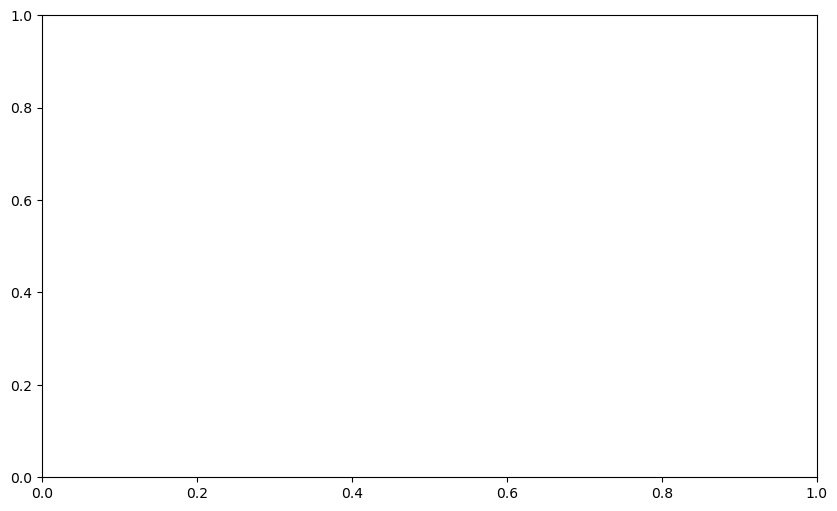

In [62]:
env = make_vec_env(TradeEnv, n_envs=1, env_kwargs={'df_list': df_list})

model = RecurrentPPO(RecurrentActorCriticPolicy, 
                     env, 
                     verbose=1, 
                     batch_size=32, 
                     n_steps=200, 
                     learning_rate=0.00025,
                     gamma=0.99, 
                     gae_lambda=0.95, 
                     clip_range=0.2,
                     clip_range_vf=None,
                     ent_coef=0.01, 
                     vf_coef=0.5, 
                     max_grad_norm=0.5,
                     use_sde=False, 
                     sde_sample_freq=-1, 
                     target_kl=None, 
                     tensorboard_log=None,
                     seed=43, 
                     device="auto", 
                     _init_setup_model=True,
                     policy_kwargs={
                         'lstm_hidden_size': 128, 
                         'n_lstm_layers': 2,
                         'net_arch': dict(pi=[256, 256], vf=[256, 256]),
                         'activation_fn': torch.nn.ReLU
                     })

model.learn(total_timesteps=7000)

In [63]:
model.save("trade_bot")
del model
model = RecurrentPPO.load("trade_bot")

/var/folders/k4/9m82lrns3_b1px7jygrrtg300000gn/T/ipykernel_50946/479124300.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.currency_df = np.random.choice(self.dataframes)


{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Profit': 0, 'Cash': 1017.1380113264455, 'Shares Owned': 0}
Action: 2 - Profit: 0
{'Pr

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 5

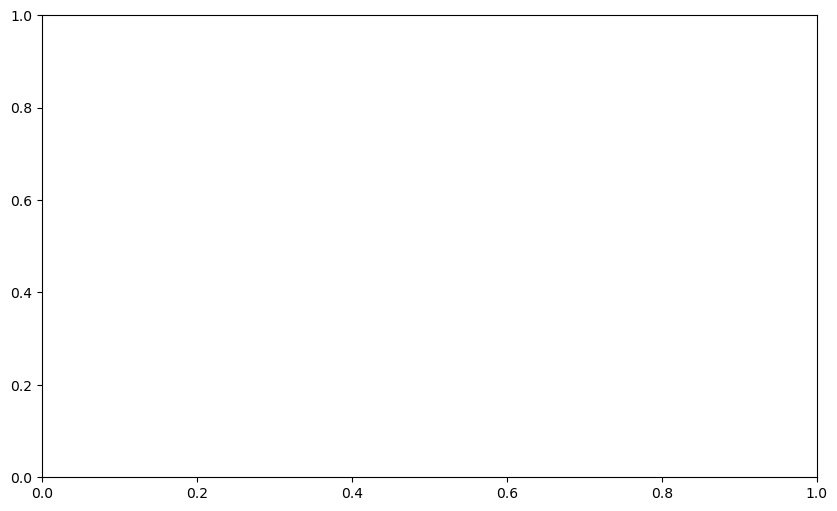

In [65]:
# Create a test environmant
env = TradeEnv(df_list=df_list)

# Create the required variables for calculation
done = False
truncated = False

# Predict the test values with the trained model
obs, _ = env.reset()
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, done, truncated, info = env.step(action)

    print(f"Action: {action} - Profit: {info['Profit']}")